# Building makemore Part 3: Activations & Gradients, BatchNorm

https://youtu.be/P6sfmUTpUmc?si=3VY6DI9AuO_UmyQa

https://github.com/karpathy/makemore

https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb

https://colab.research.google.com/drive/1H5CSy-OnisagUgDUXhHwo1ng2pjKHYSN?usp=sharing

Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
https://arxiv.org/abs/1502.01852

Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
https://arxiv.org/abs/1502.03167

A Neural Probabilistic Language Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Rethinking "Batch" in BatchNorm
https://arxiv.org/abs/2105.07576


### Exercises:

-E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

-E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.


In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [65]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-16 17:56:26--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-16 17:56:27 (5.98 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [66]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print("Len of words", len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Len of words 32033


In [67]:
# build the vocabulary of chars and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [68]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [69]:
# MLP
n_embd = 10 # the dimensiality of chars embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 0.1 # * 0.1 = fix for saturated tanh
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # * 0.01 = fix for saturated tanh
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # * 0.01 = fix logits extreme values (see notes below)
# Why not to set W2 to * 0? :) I had the same idea ^_0
b2 = torch.randn(vocab_size,                        generator=g) * 0 # * 0 = fix logits extreme values (see notes below)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

11897


In [70]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]                             # embed chars into vector
  embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
  # hpreact is too far from 0 and this causes the saturated tanh issue - see below
  hpreact = embcat @ W1 + b1              # hidden layer pre-activation
  h = torch.tanh(hpreact)                 # hiddent layer
  logits = h @ W2 + b2                    # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad


  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # let's put a break - we want to see the initial loss
  # break

# we get loss:
# 0/ 200000: 27.8817
# 10000/ 200000: 2.9415
# ...
# As you see the loss is very high in the beginning, it means that initiliazation is wrong!
# You can estimate the initial loss, by looking to the data and what you do with it.
# In our case the distribution should be uniform for all 27 chars, equal probability for
# all 27 chars.
# So probability for each char will be 1/27, and loss we expect should be
# -torch.tensor(1/27.0).log()
# The issue is with logits, we want to have logits equal during init.

      0/ 200000: 3.3069
  10000/ 200000: 2.1900
  20000/ 200000: 2.2707
  30000/ 200000: 2.4296
  40000/ 200000: 1.9041
  50000/ 200000: 2.3865
  60000/ 200000: 2.3392
  70000/ 200000: 2.0873
  80000/ 200000: 2.2595
  90000/ 200000: 2.1146
 100000/ 200000: 1.8817
 110000/ 200000: 2.1622
 120000/ 200000: 1.8919
 130000/ 200000: 2.3128
 140000/ 200000: 2.3481
 150000/ 200000: 2.1759
 160000/ 200000: 1.8034
 170000/ 200000: 1.7760
 180000/ 200000: 1.8991
 190000/ 200000: 1.8666


In [71]:
logits[0]
# as you see for the first iteration logits take extreme values and this is the reason of high loss (27) on init
# On init phase logits should be close to 0 and almost equal

tensor([-0.8634,  2.1156, -0.4218, -0.7525,  0.4719,  2.1376, -2.0277, -3.9128,
        -1.2412,  2.8697, -1.9658, -2.0855,  2.7370,  1.5849,  3.7796,  1.4146,
        -0.0310, -4.5259,  1.9947,  1.4026,  0.5367, -1.1386,  0.2740, -1.8397,
        -2.7172,  2.6637, -0.0090], grad_fn=<SelectBackward0>)

tensor([[ 0.9914,  0.0388, -0.9993,  ..., -0.9982, -0.2723, -0.9905],
        [-0.7298, -0.0758, -0.7268,  ..., -0.9974, -0.2481, -0.9625],
        [-0.9970,  0.2337, -0.8384,  ...,  0.9713, -0.7985,  0.9917],
        ...,
        [-0.1411,  0.0353, -0.1923,  ..., -0.6255, -0.9462, -0.9884],
        [ 0.9864, -0.0649,  0.9995,  ..., -0.9990,  0.6749,  0.9467],
        [-0.9736,  0.0835, -1.0000,  ...,  0.5896,  0.9017,  0.0349]],
       grad_fn=<TanhBackward0>)
torch.Size([32, 200])
torch.Size([6400])
[0.9913684129714966, 0.03881940245628357, -0.9993338584899902, -0.9991230964660645, 0.9882665872573853, -0.9408980011940002, -0.9344831109046936, -0.8125219941139221, 0.731650173664093, -0.18336693942546844, -0.4699220061302185, 0.9999609589576721, 0.5595118403434753, -0.966949462890625, 0.06061103194952011, -0.3814535140991211, 0.9777988195419312, -0.0028837542049586773, -0.9994491338729858, -0.8867168426513672, 0.6979530453681946, -0.826448917388916, -0.02102634310722351, 0.996479928493

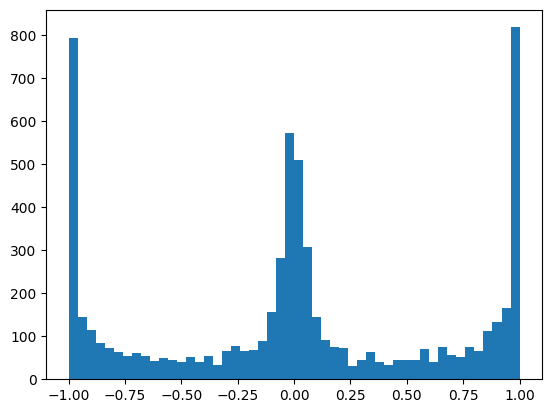

In [72]:
# but there is a deeper problem - with h - saturated tanh
# with a break (only with one iteration) - do you see how many -1, +1
# tanh is a squashing fn
print(h)
print(h.shape)
print(h.view(-1).shape) # stretching to one vector
print(h.view(-1).tolist()) # convert to a list
plt.hist(h.view(-1).tolist(), bins=50); # ; supress output
# on histogram it is more visible, that most values have values -1 and +1
# As you can guess it is not good :/
# From micrograd tanh backpropagation calculated:
# self.grad += (1-t**2) * out.grad
# if t = -/+1 the self grad will become 0
# basically in other words, changing input won't change tanh too much
# if t is 0, tanh is not active and gradient just pass through

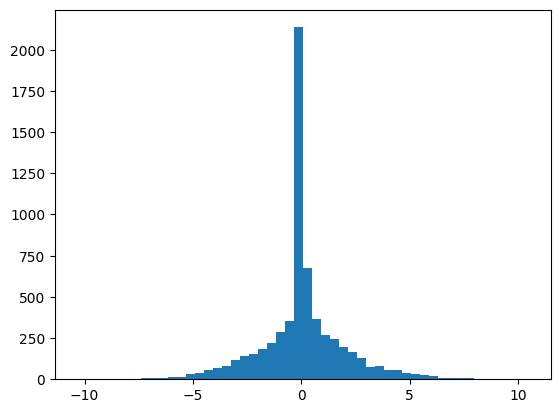

In [73]:
plt.hist(hpreact.view(-1).tolist(), bins=50); # ; supress output

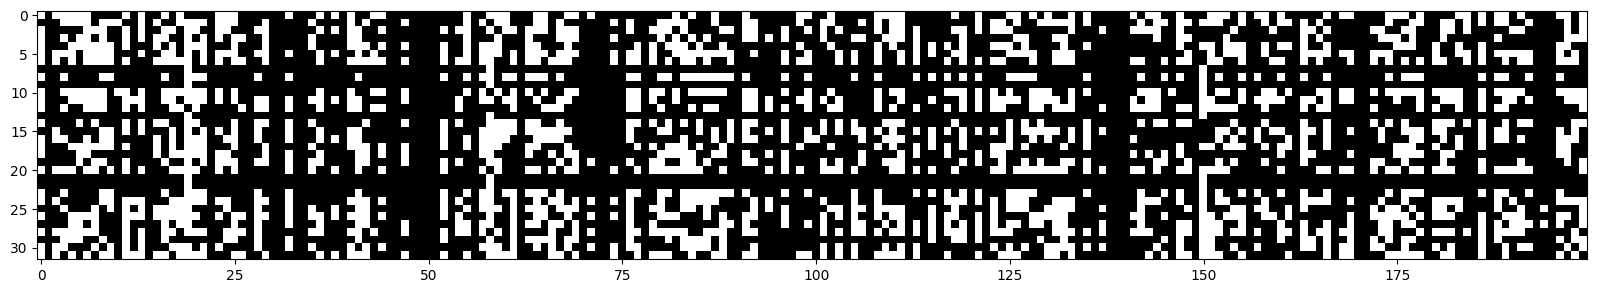

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.9, cmap='gray', interpolation='nearest');
# all white tanh neurons are very active and they are in a flat tail
# if entire column is white - it is a huge problem = dead neuron, it means that no single example
# never activates tanh, this neuron will never learn
# Activation fn:
# - Sigmoid
# - tanh
# - ReLU
# - Leaky ReLU - no flat tail
# - Maxout
# - ELU

In [75]:
-torch.tensor(1/27.0).log()
# This loss we expect on the initialization!

tensor(3.2958)

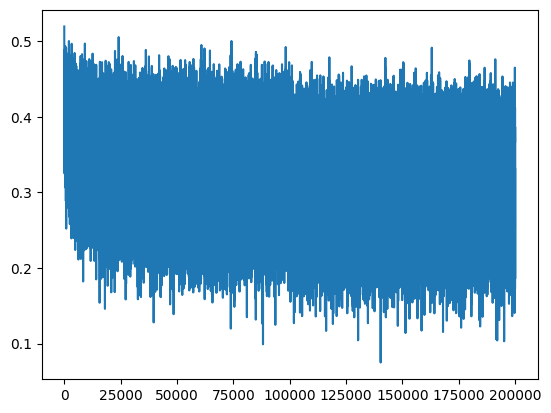

In [76]:
plt.plot(lossi)
# after adjusting logits for a proper init the loss does not look like a hookey stick
# and this is good!

In [77]:
# The @torch.no_grad() decorator in PyTorch is used to disable gradient calculation
# for the operations within the function it decorates. This is useful when you're
# performing inference (i.e., not training), because:
# - It reduces memory usage, since no intermediate activations need to be stored for backpropagation.
# - It improves performance, since no gradients are calculated or stored.
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.05790114402771
val 2.113706350326538


In [78]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all..

  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, block, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
ndyn.
alee.
thrithadrie.
cadelyn.
elin.
shi.
jenne.
elisson.
arleiyah.
houra.
nosalbergiaghiel.
kindrenlynn.
noella.
ubekteder.
yaquineh.
yuma.
muston.


# loss log

## original
train: 2.12
val: 2.16

## fix softmax confidently wrong
train: 2.07
val: 2.13

## fix tanh too saturated at init
train: 2.03
val: 2.10

!Values are from the lecture, not mine

### The deeeper your neural network, all init issues stack up and sometimes NN cannot train at all.

### The shallow NN is more forgiving!

# Currently we use magic numbers to deal with init issues described above.

How did we get 0.1 or 0.01.

How to deal with them when NN is big?!

Lets fix them.

In [79]:
# MLP
n_embd = 10 # the dimensiality of chars embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size) **0.5 # * 0.1 = fix for saturated tanh
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # * 0.01 = fix for saturated tanh
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # * 0.01 = fix logits extreme values (see notes below)
# Why not to set W2 to * 0? :) I had the same idea ^_0
b2 = torch.randn(vocab_size,                        generator=g) * 0 # * 0 = fix logits extreme values (see notes below)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

11897


x tensor(0.0063) tensor(1.0016)
w tensor(0.0093) tensor(0.3128)
y tensor(-0.0036) tensor(0.9891)


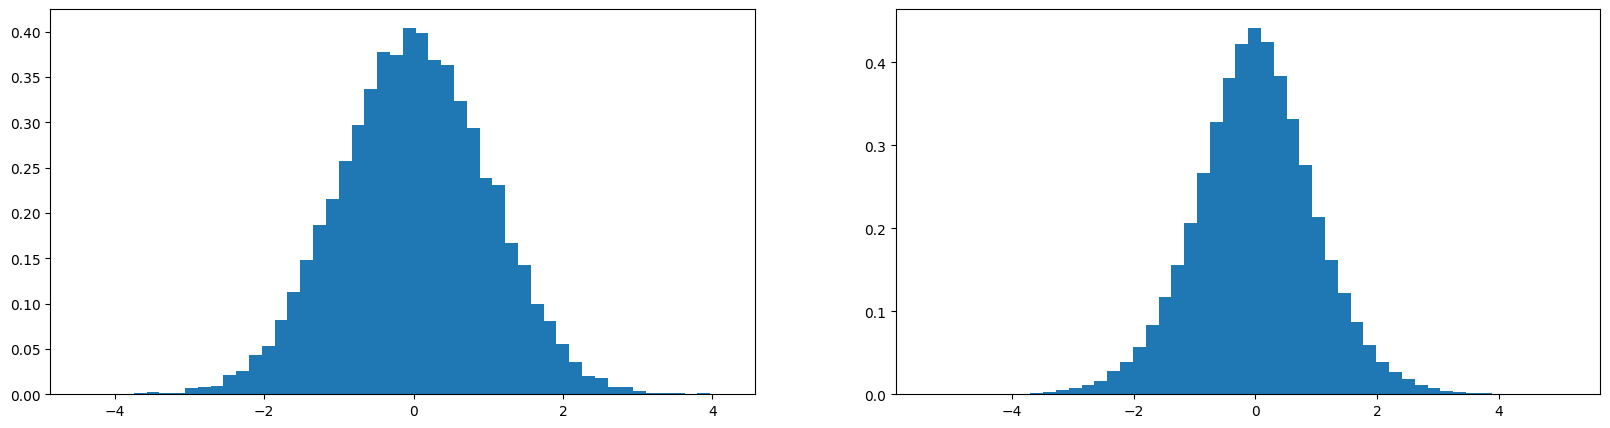

In [80]:
# here is an example:
# if we look to x distribution from -3 to 3 Gaussian, check standard deviation
# but for y we have distribution from -10 to 10
# We want to select w in way to preserve the original distribution, to remain Gaussian!
# We want to preserve standard deviation!

x = torch.randn(1000, 10)
# math speaking we need to divide w to fan-in square root,
# where fan-in is  the number of input connections to a neuron or computational
# unit in a layer. It is commonly used in the context of initializing neural
# network weights and analyzing the architecture.
# To scale we use Xavier/Glorot initialization and He initialization use fan-in
# (and sometimes fan-out) to scale the weights
# See: Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
# https://arxiv.org/abs/1502.01852
# and instead of re-inveting the wheel we can use torch methods:
# torch.nn.kaiming_normal - currently it is the most common way to init NN
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print("x", x.mean(), x.std())
print("w", w.mean(), w.std())
print("y", y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

In [81]:
torch.randn(1000).std()

tensor(1.0014)

In [82]:
# gain /
(5/3) / 30**0.5

0.3042903097250923

In [83]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]                             # embed chars into vector
  embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
  # hpreact is too far from 0 and this causes the saturated tanh issue - see below
  hpreact = embcat @ W1 + b1              # hidden layer pre-activation
  h = torch.tanh(hpreact)                 # hiddent layer
  logits = h @ W2 + b2                    # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad


  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # let's put a break - we want to see the initial loss
  # break

# we get loss:
# 0/ 200000: 27.8817
# 10000/ 200000: 2.9415
# ...
# As you see the loss is very high in the beginning, it means that initiliazation is wrong!
# You can estimate the initial loss, by looking to the data and what you do with it.
# In our case the distribution should be uniform for all 27 chars, equal probability for
# all 27 chars.
# So probability for each char will be 1/27, and loss we expect should be
# -torch.tensor(1/27.0).log()
# The issue is with logits, we want to have logits equal during init.

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [84]:
# The @torch.no_grad() decorator in PyTorch is used to disable gradient calculation
# for the operations within the function it decorates. This is useful when you're
# performing inference (i.e., not training), because:
# - It reduces memory usage, since no intermediate activations need to be stored for backpropagation.
# - It improves performance, since no gradients are calculated or stored.
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [85]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all..

  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, block, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
see.
madhayla.
ren.
ruthndraeg.
adelyn.
elin.
shi.
jen.
eden.
est.
aaraelyzion.
kamin.
shuberlyni.
jest.
jair.
jeniqueterian.
brence.
ryyah.


# Currently the right init is not super important, because there are other things that improved NN:

- batch normalization [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [92]:
# MLP
n_embd = 10 # the dimensiality of chars embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size) **0.5 # * 0.1 = fix for saturated tanh
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # * 0.01 = fix for saturated tanh
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # * 0.01 = fix logits extreme values (see notes below)
# Why not to set W2 to * 0? :) I had the same idea ^_0
b2 = torch.randn(vocab_size,                        generator=g) * 0 # * 0 = fix logits extreme values (see notes below)

# scale and shift for batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# this is solution - how to avoid extra step of calculation after training:
# we are going to calculate it dynamically during training! ^_0
# buffers for bnmean and bnstd
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# remove b1, because we don't use it - see cell below with explanation!
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

12097


In [87]:
hpreact.shape

torch.Size([32, 200])

In [88]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [89]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [93]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct -----------
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass -------------
  emb = C[Xb]                             # embed chars into vector
  embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
  # the idea - we want to make hpreact roughly Gaussian only during init phase
  # we don't want to keep it Gaussian later
  # --------------

  # hidden layer pre-activation
  # + b1 # bias is not needed due to use bnmean/bnstd, we substruct bnmean
  # and it makes basically bias equal to 0
  # Linear layer -----------
  hpreact = embcat @ W1
  # ------------

  # Batch norm layer ----------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = hpreact - bnmeani # subtract mean
  hpreact = hpreact / bnstdi # divide by std
  hpreact = bngain * hpreact + bnbias # scale and shift
  #---------------

  # update values! without gradient descent ----------
  with torch.no_grad():
    #                                       + momentum
    # if batch size is small momentum is 0.1 is dangerous, because std will move too much during training!
    # momentum 0.1 is default in pytorch -> https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    # affine = True is to keep bngain and bnbias
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ---------------

  h = torch.tanh(hpreact)                 # hiddent layer
  logits = h @ W2 + b2                    # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass ------------
  for p in parameters:
    p.grad = None
  loss.backward()
  # --------------

  # update ---------------
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  # ---------------

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [95]:
# calibrate the batch norm after training
# this is necessary for sampling
"""
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire dataset
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  # we calculate bnmean and bnstd for entire dataset
  # in reality noone wants to estimate bnmean and bnstd after training, the best
  # solution is to estimate it during training :)
"""
# bnmean_running and bnstd_running should be close to bnmean adn bnstd,
# it is not identical, but very close

'\nwith torch.no_grad():\n  emb = C[Xtr]\n  embcat = emb.view(emb.shape[0], -1)\n  hpreact = embcat @ W1 + b1\n  # measure the mean/std over the entire dataset\n  bnmean = hpreact.mean(0, keepdim=True)\n  bnstd = hpreact.std(0, keepdim=True)\n  # we calculate bnmean and bnstd for entire dataset\n  # in reality noone wants to estimate bnmean and bnstd after training, the best\n  # solution is to estimate it during training :)\n'

In [94]:
# The @torch.no_grad() decorator in PyTorch is used to disable gradient calculation
# for the operations within the function it decorates. This is useful when you're
# performing inference (i.e., not training), because:
# - It reduces memory usage, since no intermediate activations need to be stored for backpropagation.
# - It improves performance, since no gradients are calculated or stored.
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = hpreact - hpreact.mean(0, keepdim=True) # subtract mean
  # hpreact = hpreact / hpreact.std(0, keepdim=True) # divide by std
  # hpreact = bngain * hpreact + bnbias # scale and shift
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # subtract mean

  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674192905426025
val 2.105670690536499


# Batch normalization comes with a cost!

It has a regularizing sideeffect, which is not bad.

How do we get sample from NN, in our case it expects a batch, due to batch normalization. We need to add an additional step after training - calibration of the batch

In [96]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all..

  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, block, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated word

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrekesslangfarremyahmilkarib.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymphi.
qhiyrahshvykoldnihannaviyahsufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthziroisticlitgftrvissivishmellakethrishldahmaudkeshdekitya.
blvardtaiweddie.
virlq.
saadenaysophlrystta.
ziyah.
vontet.
judnylissaphrygnovevt.
jshmptrykshmphithlisandvekessamariopsi.


For real example search for Resnet (residual NN - for image classification)

# SUMMARY + PYTORCHIFYING -----------

In [97]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
# Compare the code below with actual torch imlementation!
# https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


# https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
class BatchNorm1d:
  # eps (epsilon) is a small constant added to the variance to prevent division
  # by zero or very small numbers, which could cause numerical instability
  # in our case affine is True - we will use gamma and beta (bngain and bnbias) for init
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    # similar to pytorch - define is the mode training or test
    self.training = True
    # parameters (trained with backprop), actually just bngain and bnbias
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    # pytorch does not have out attribute
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# just calculates tanh
# https://docs.pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# because of BatchNorm we can change gain and it almost do no effect on output
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [98]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # keep track ration grad/data for every iteration - see plot below
  # standard deviation of update / actual data of this parameter
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

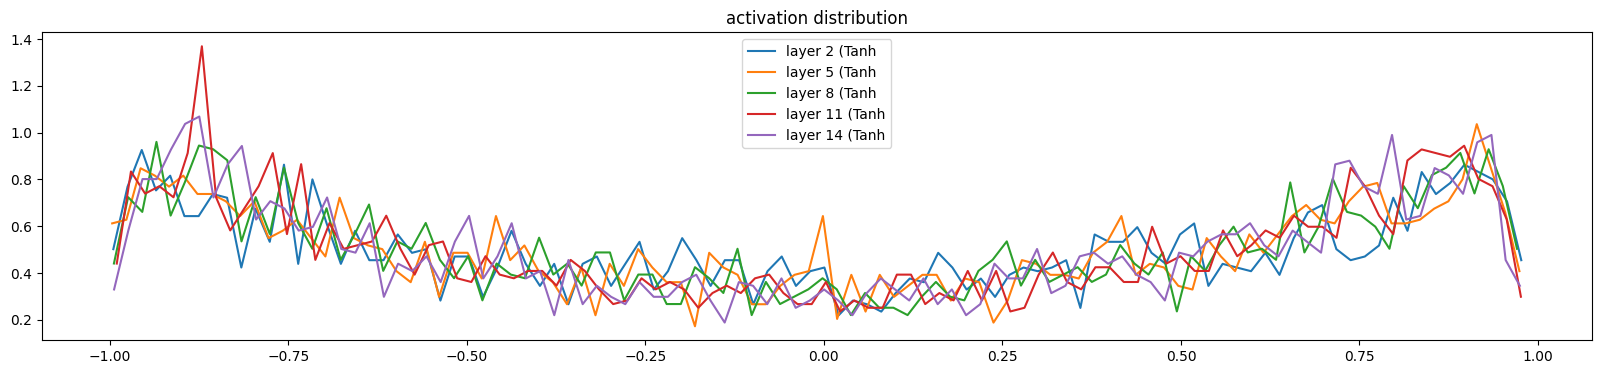

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

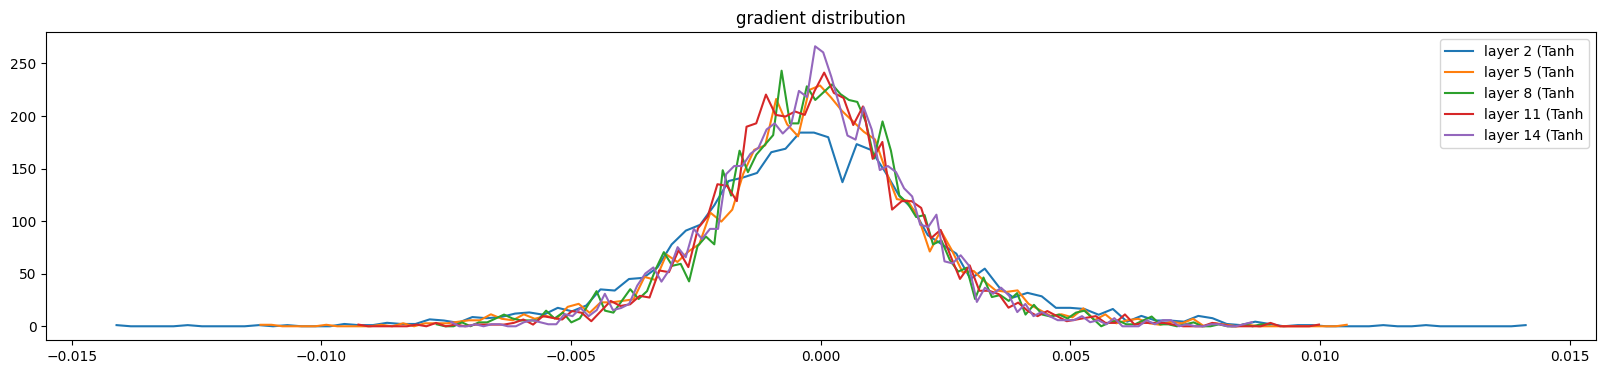

In [100]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
# all layers stay in the same gradient
# nothing shrinking, or exloading

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


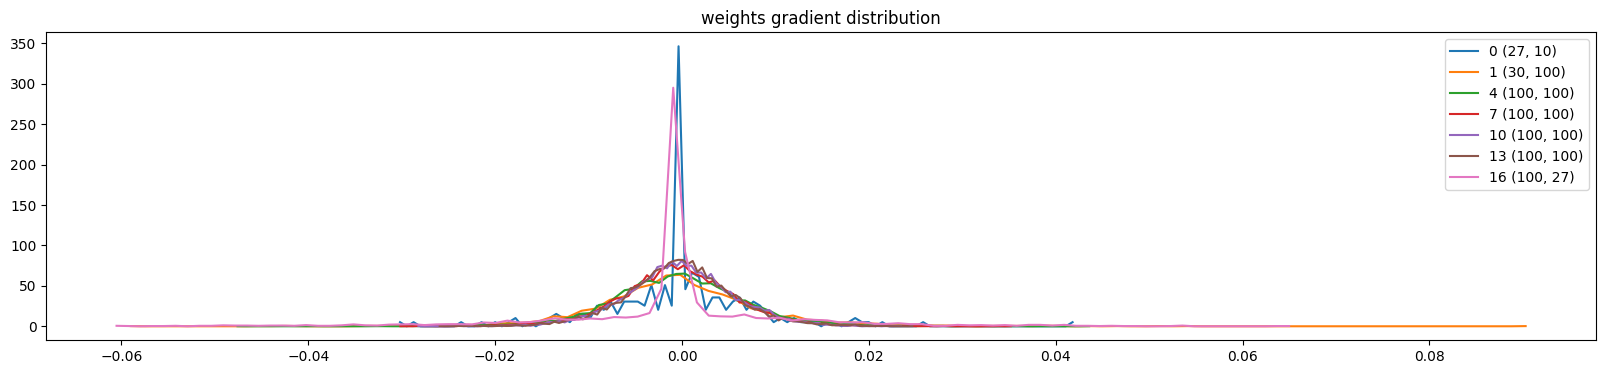

In [103]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

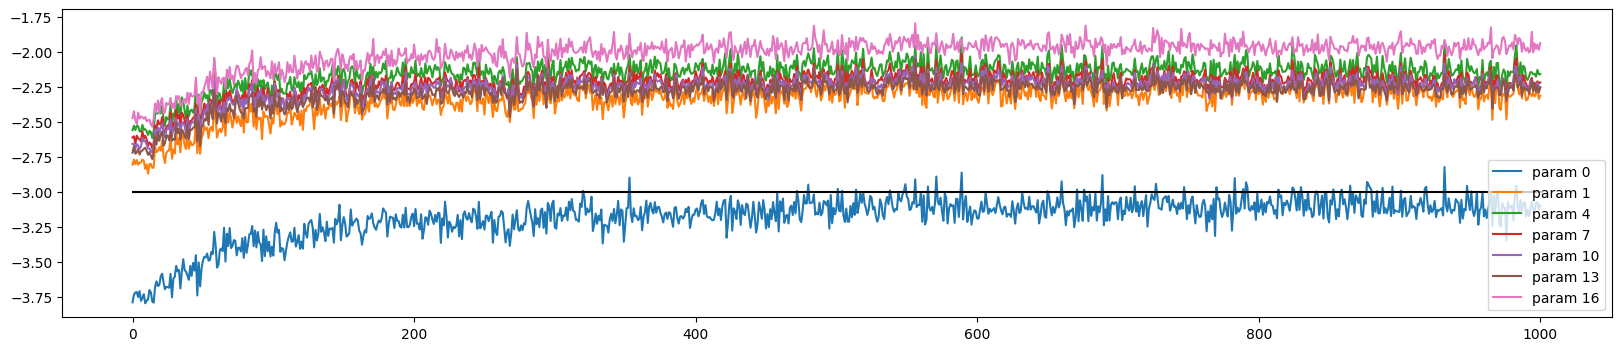

In [102]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [104]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [105]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
mmyan.
seelendhnyal.
rethrsjendrleg.
ade.
kdieliin.
miloen.
ekeisean.
xarlelleimhlara.
noshdh.
rgshiries.
kin.
reneliqxnthacfiu.
zayvde.
jymeli.
ehs.
kay.
mistoyan.
hal.
salyansuiezajelveu.
